In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date, time, timedelta
from dateutil import parser
from matplotlib.lines import Line2D
import seaborn as sns
import os
import numpy as np
from scipy import stats

In [9]:
all_data_with_ICE_interaction = {}
all_data_without_ICE_interaction = {}
ICE_services = [140, 142, 144, 146, 148, 240, 242]
stations = ['Hengelo', 'Deventer', 'Apeldoorn', 'Amersfoort Centraal']
o_services = ['7900', '1700', '3600', '31300', '31400','1500', '31200', '7000', '17900']

file_s = f'Services/all_interesting_services_filtered.csv'
df = pd.read_csv(file_s, sep = ',')
df['Stop:Departure time'] = pd.to_datetime(df['Stop:Departure time'], utc=True, format='mixed', dayfirst=True)
df['Stop:Arrival time'] = pd.to_datetime(df['Stop:Arrival time'], utc=True, format='mixed', dayfirst=True)
df['Service:Date'] = pd.to_datetime(df['Service:Date'], format='mixed', dayfirst=True)


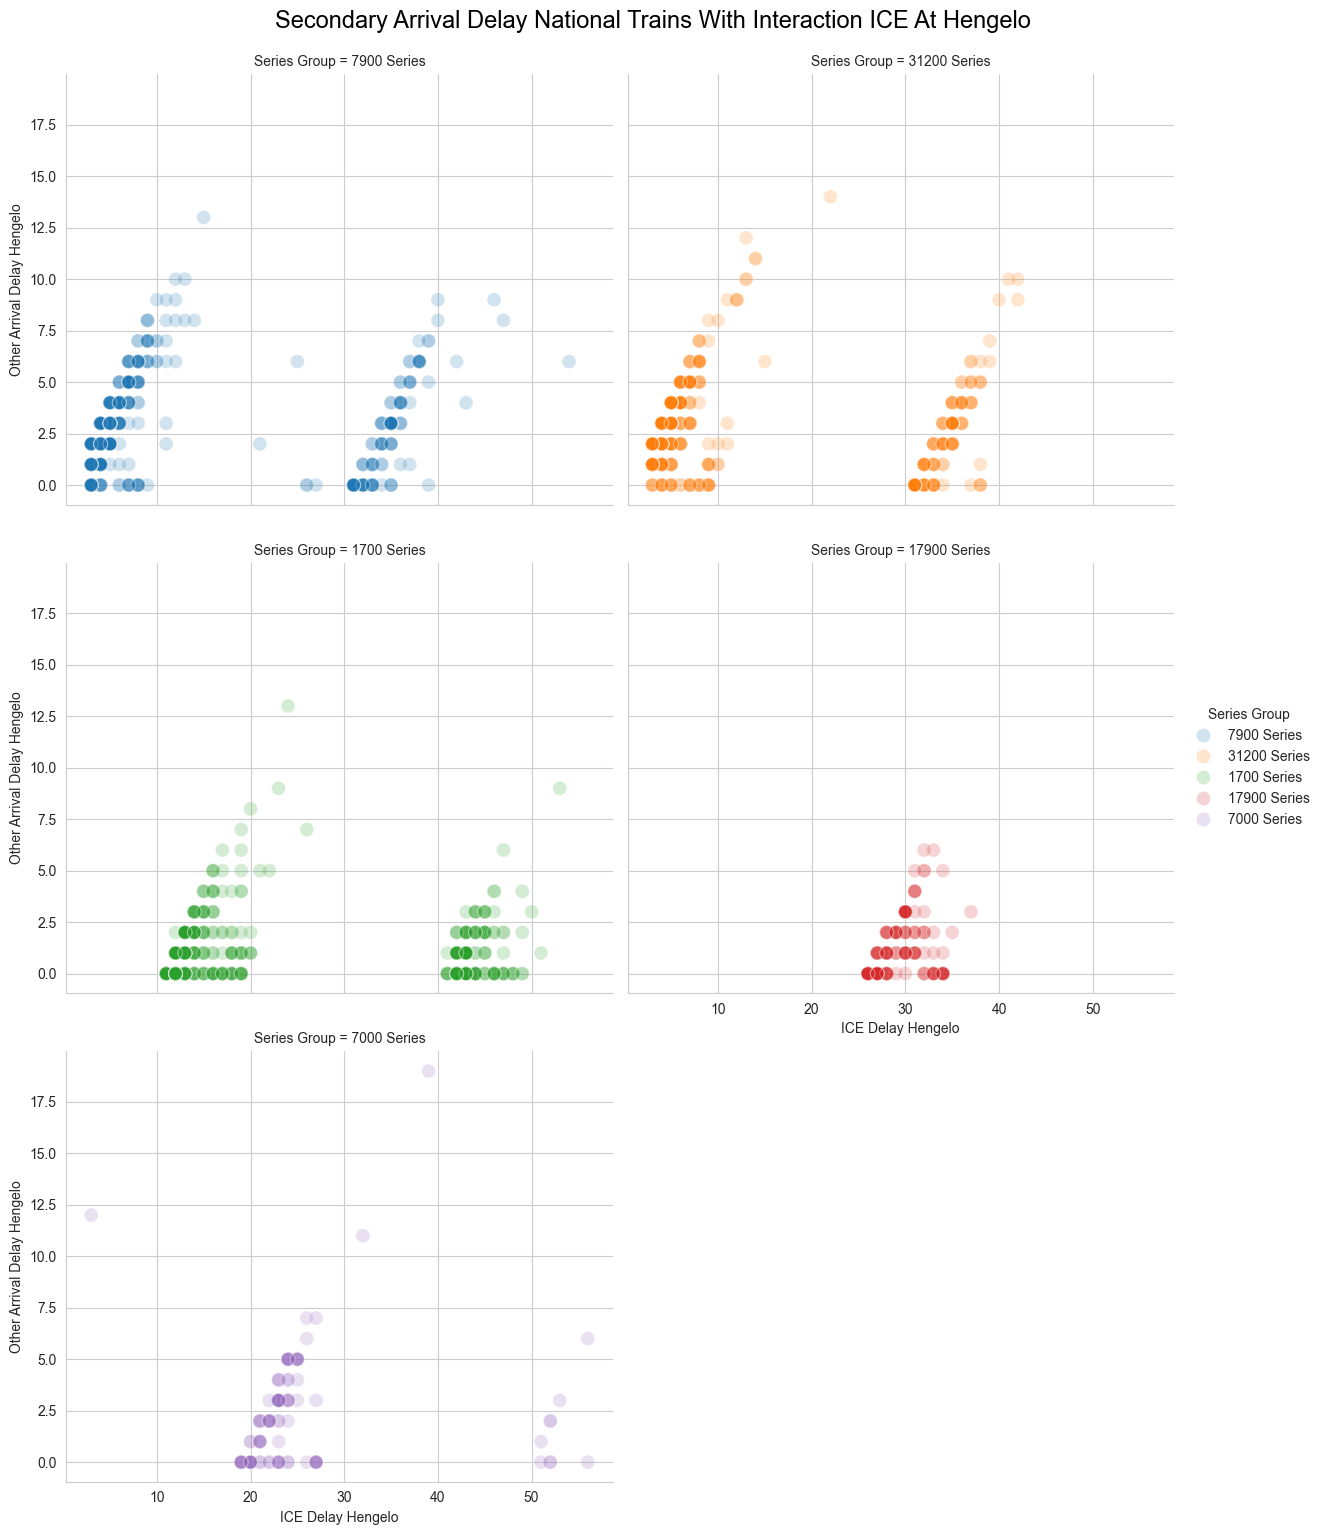

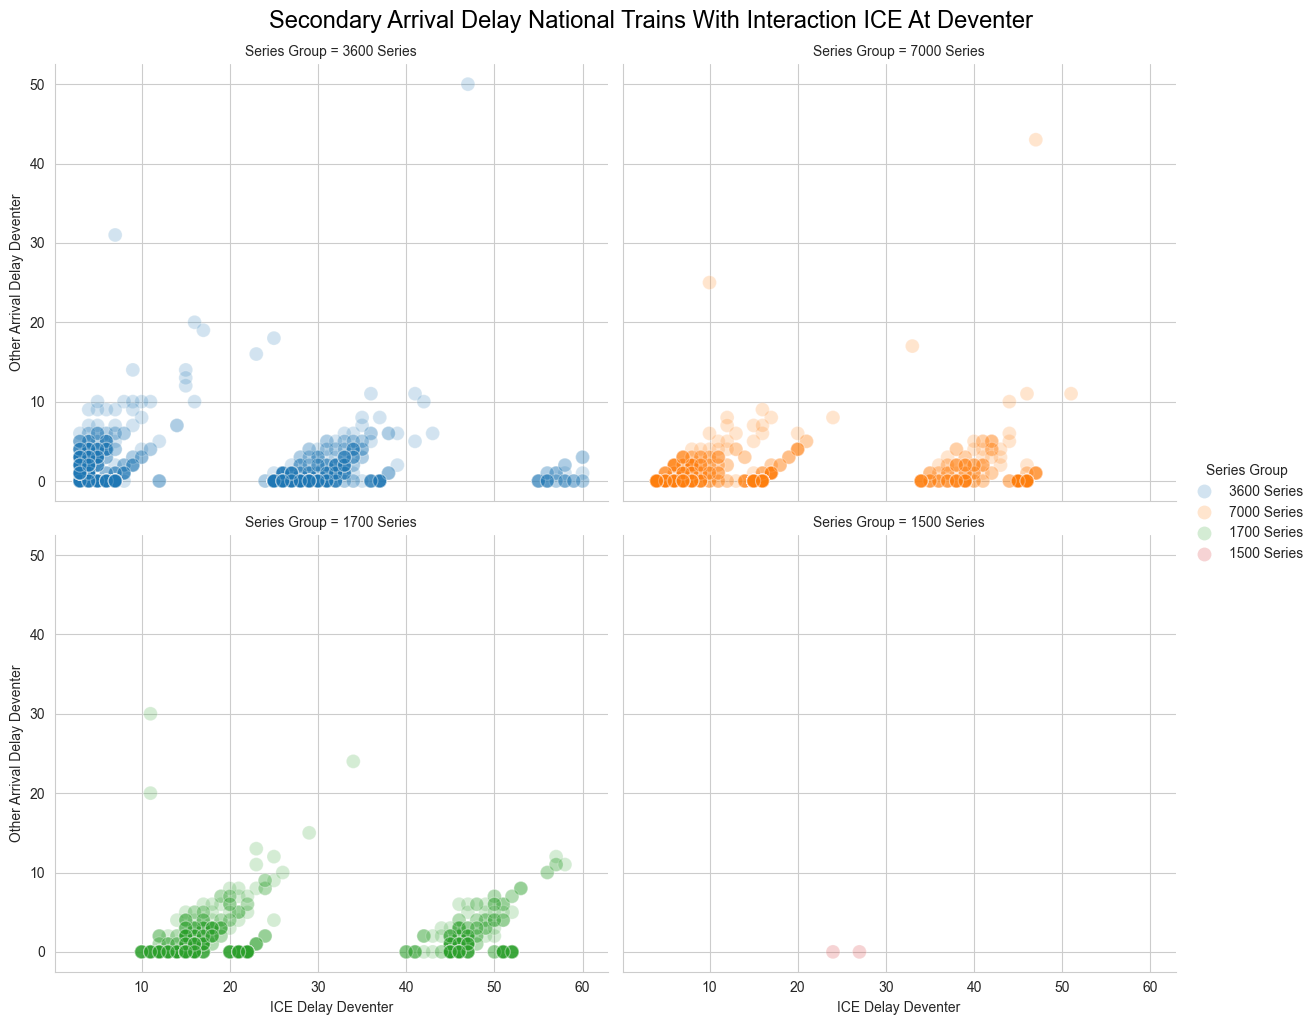

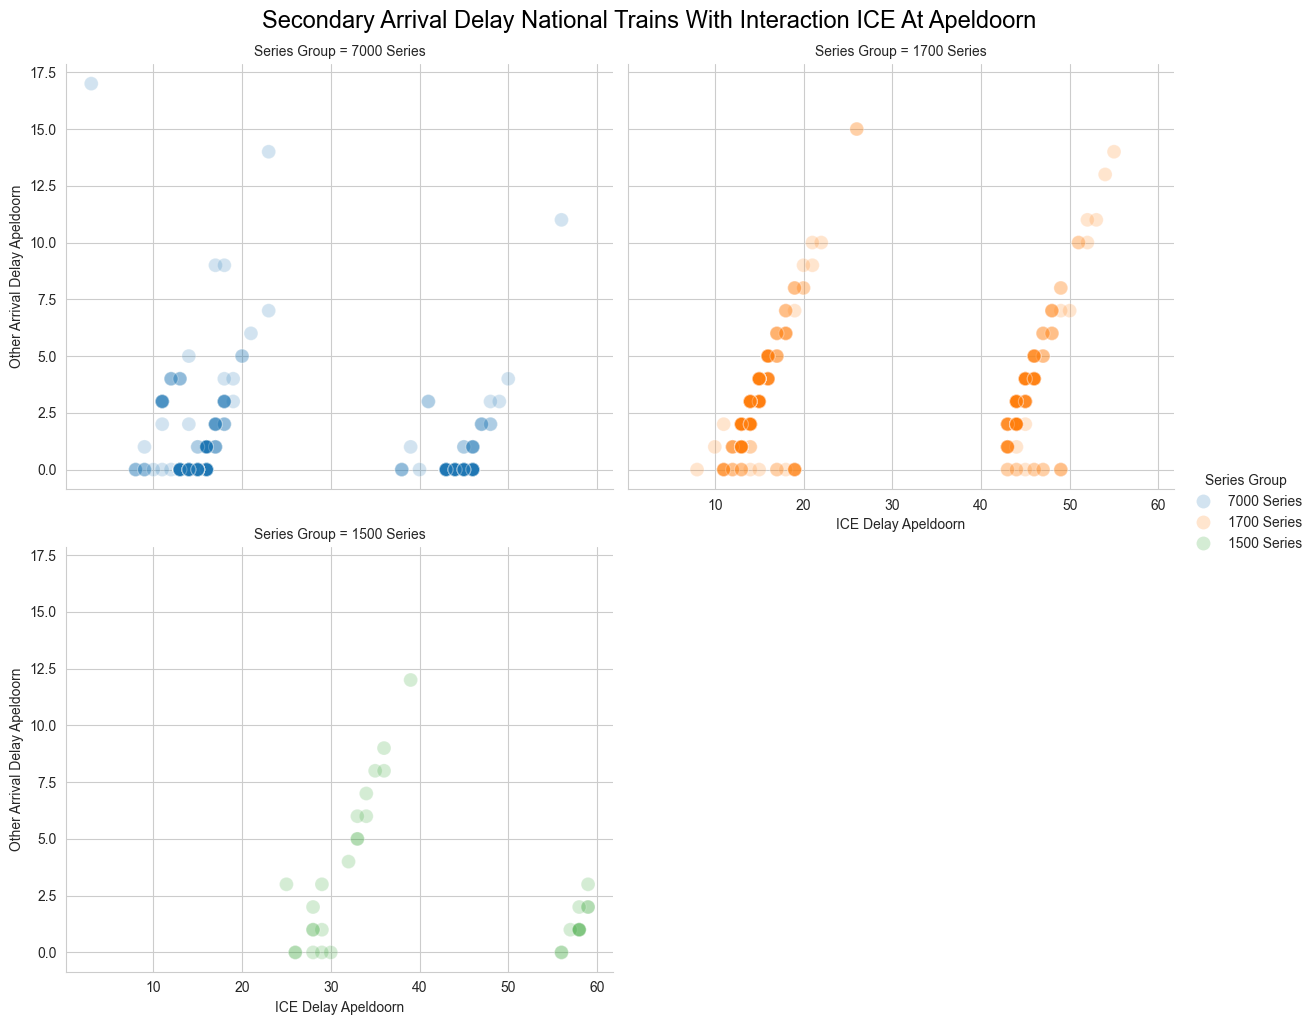

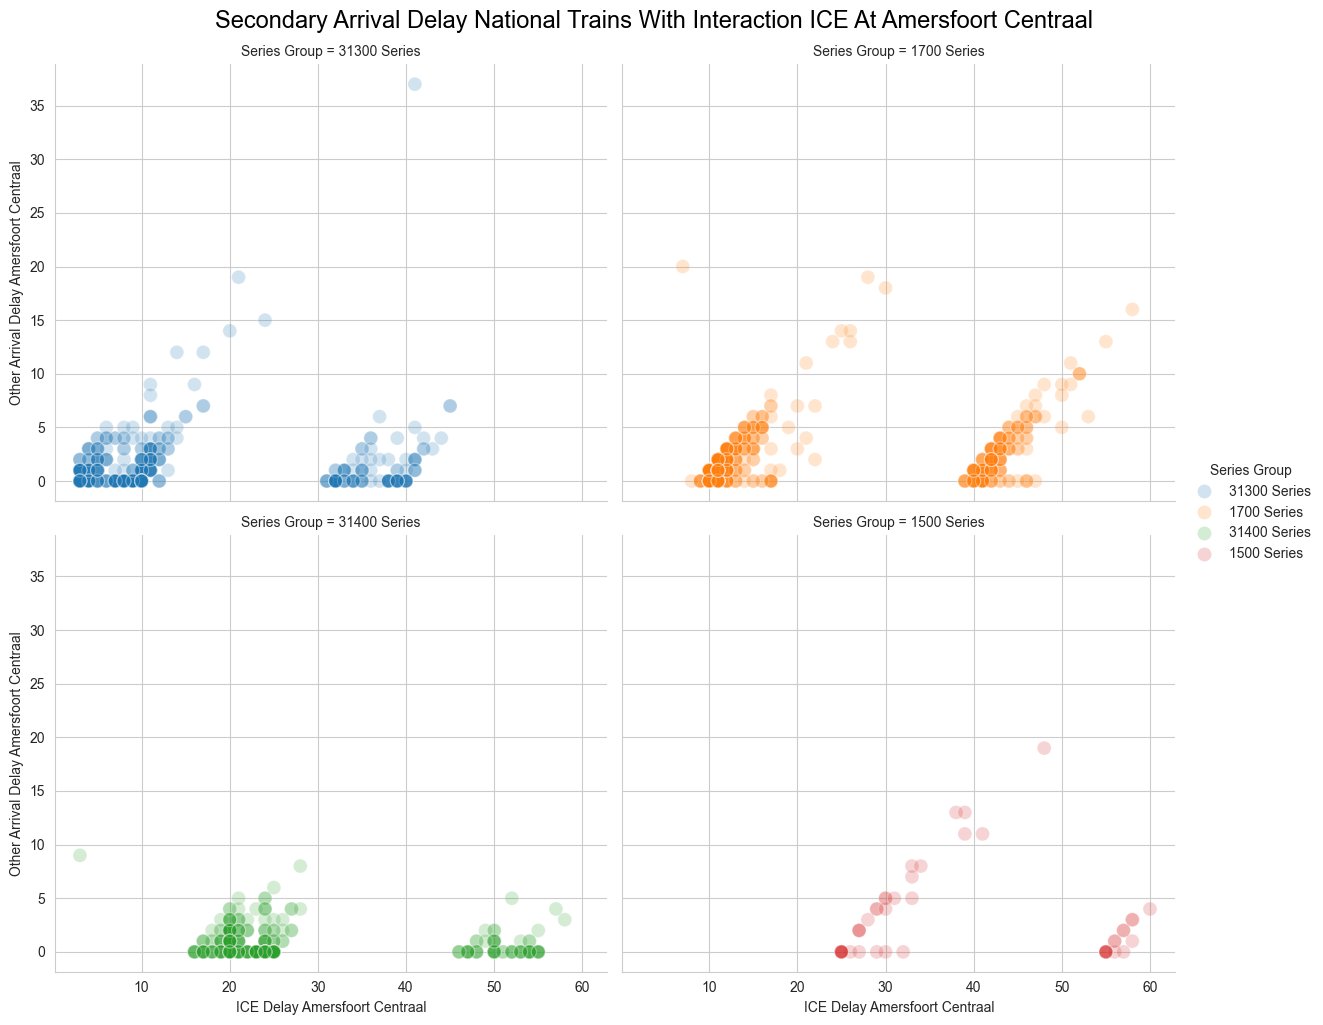

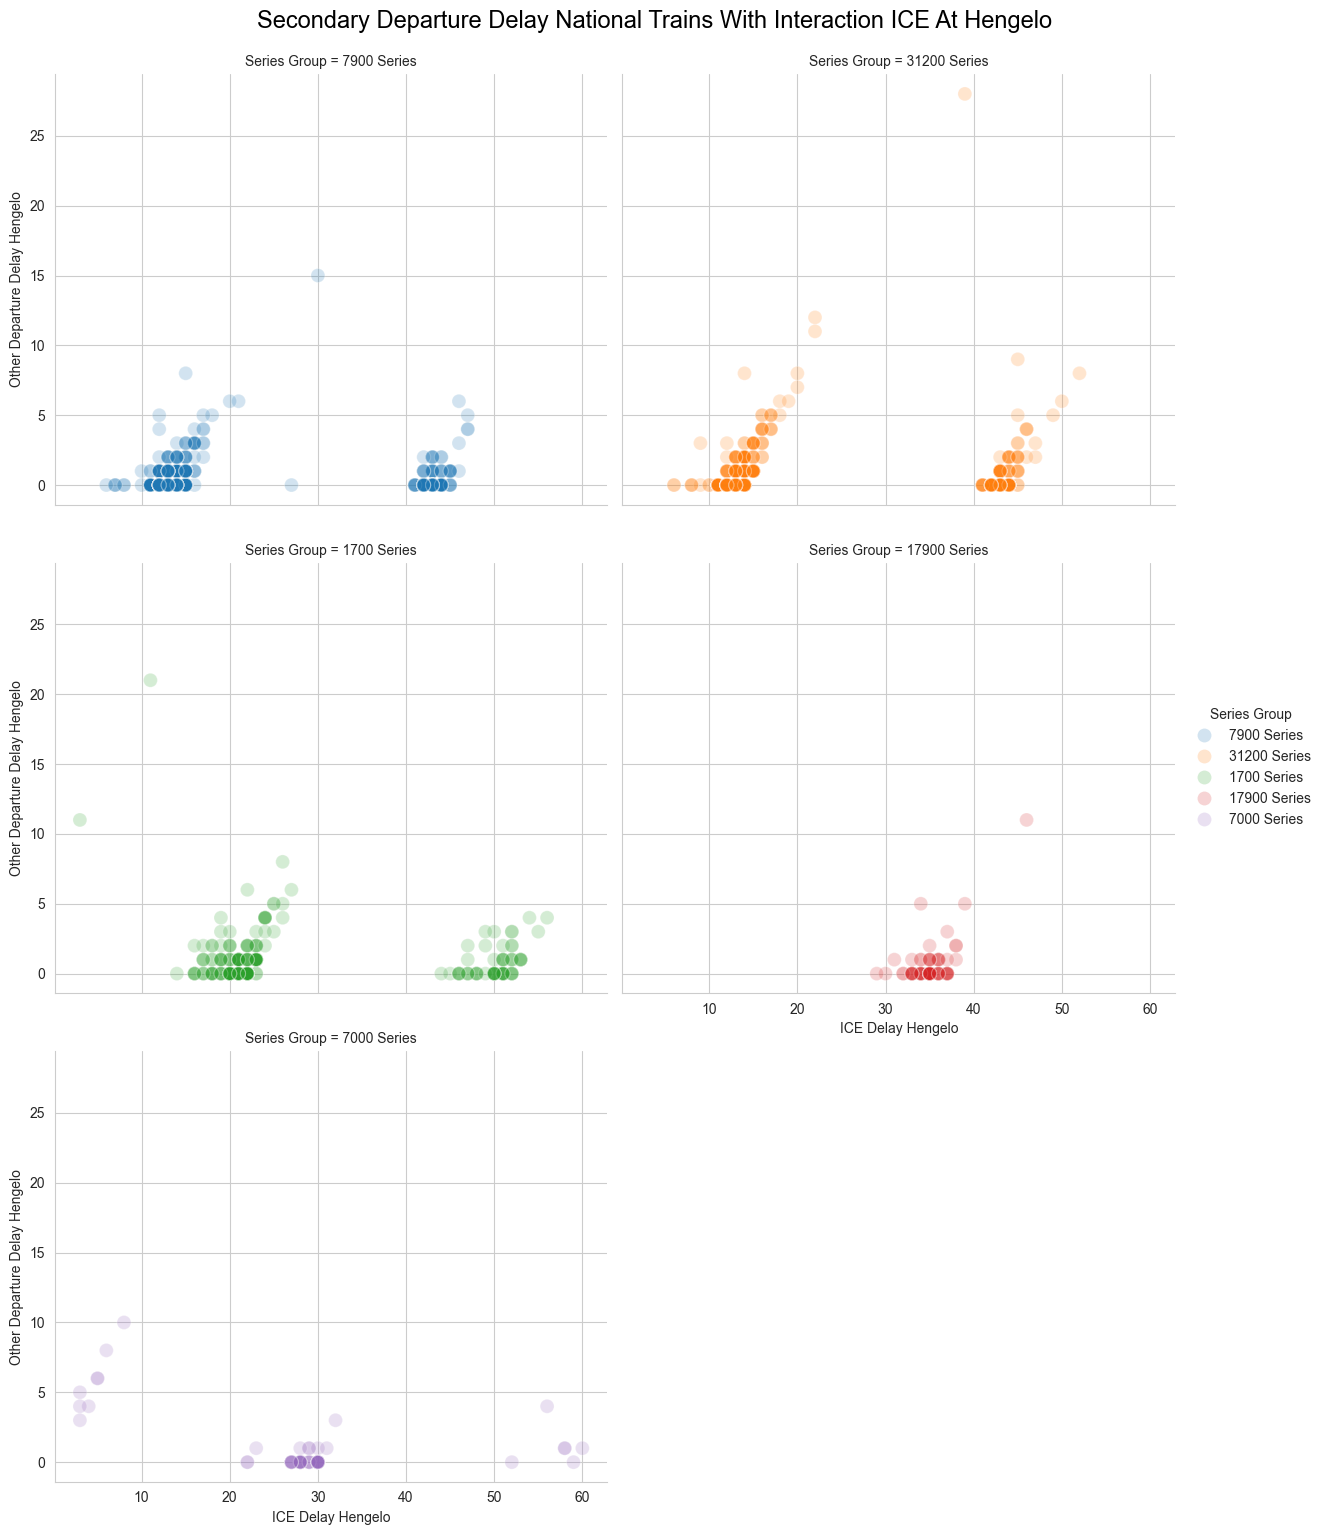

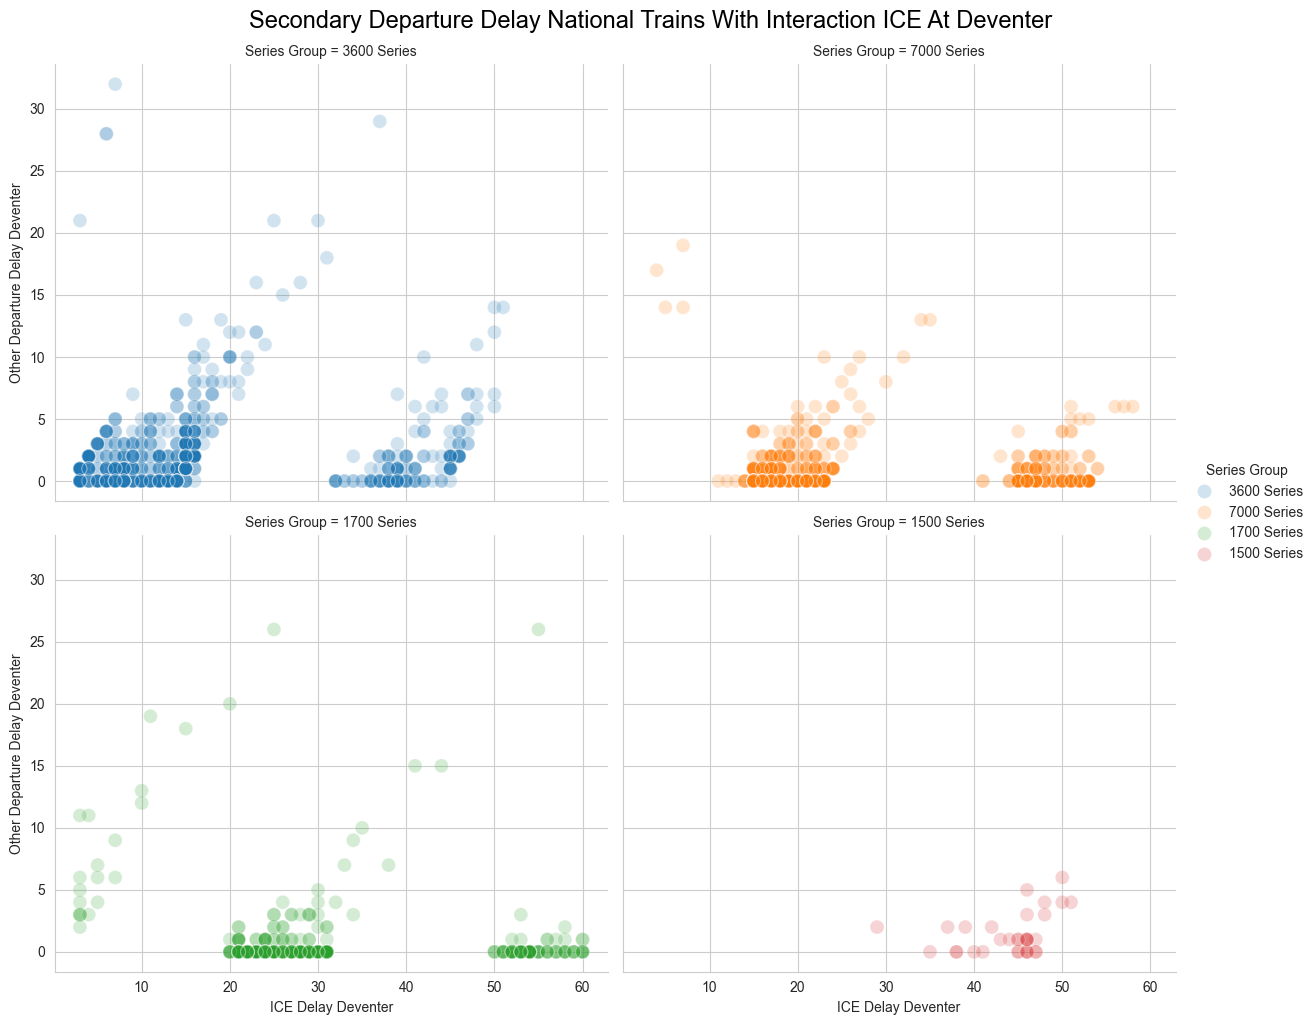

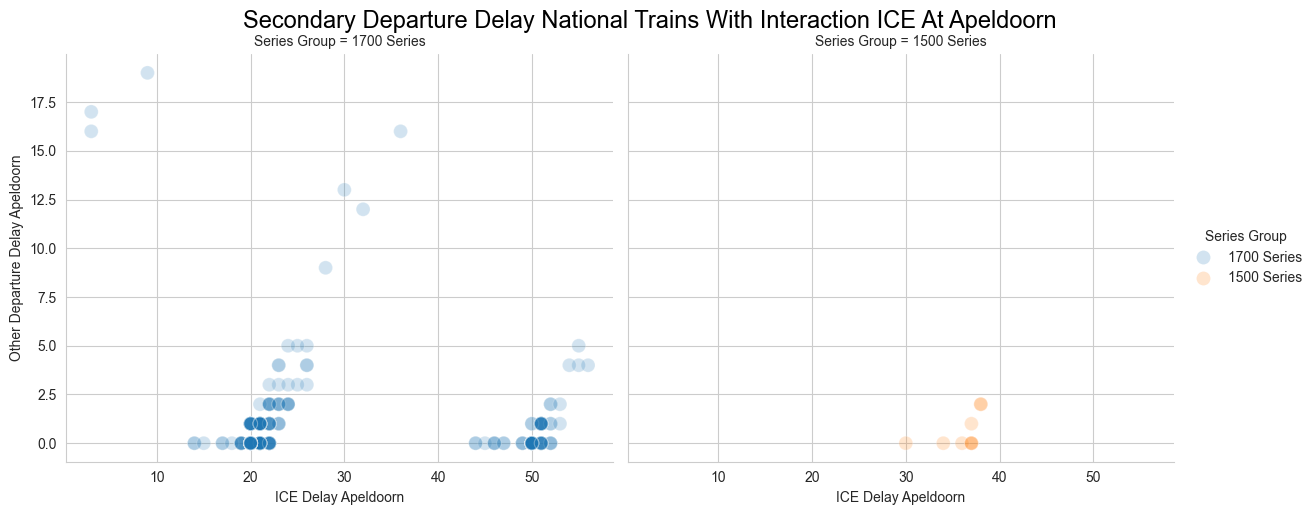

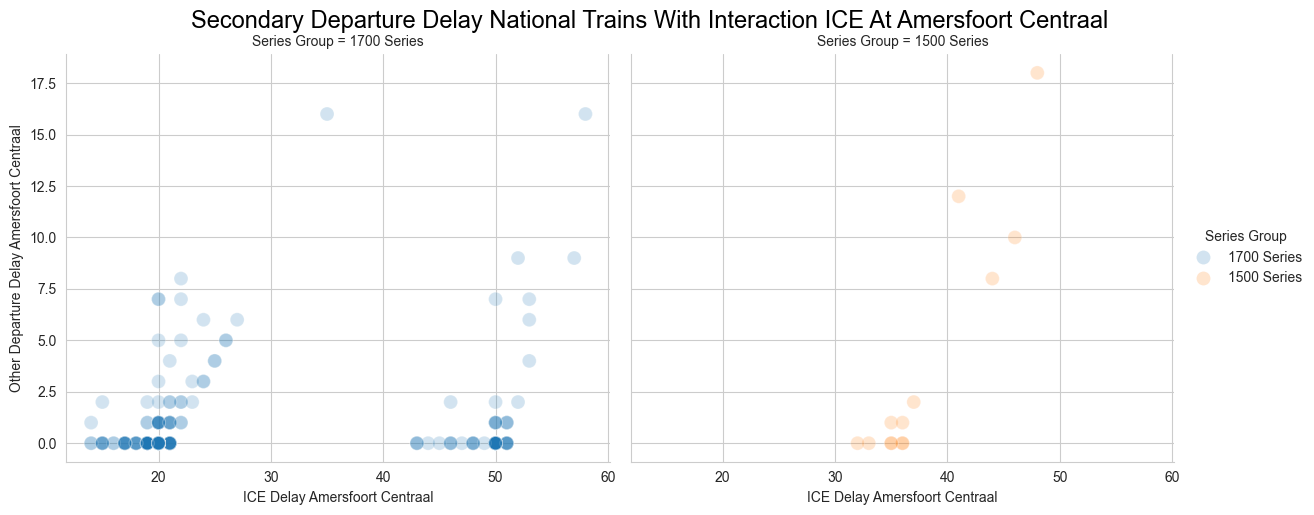

In [10]:
headway = 3
dwelltimes = {'Hengelo':2, 'Deventer': 6, 'Apeldoorn':2, 'Amersfoort Centraal': 2}
delays = ['Arrival', 'Departure']
delay_max = 60
    
### SECONDARY PLOT ###
for delay in delays:
    for i in stations:
        ICE_station = i
        interaction_all_services = []                       #All interactions for every service + the delay of the ICE at Hengelo are added in this dataframe
        for x in ICE_services:                              #For every ICE service the interactions are identified
            ICE_H = df[
                (df['Service:Train number'] == x) &         #Train is the ICE service
                (df['Stop:Station name'] == ICE_station) &  #Station 
                (df['Service:Partly cancelled']==False) &   #Only non-canceled train
                
                (df[f'Stop:Arrival delay'] <= delay_max) &  #Only delays of the ICE smaller than the delay_max are considered
                (df[f'Stop:Arrival delay'] >= 3)            #Only delays of the ICE larger than 3 are considered
            ][['Service:Date', f'Stop:Arrival delay']]
            ice_hengelo = ICE_H.rename(columns={f'Stop:Arrival delay': f'ICE Delay {ICE_station}'})

            ice_time_at_station = df[
                (df['Service:Train number'] == x) &
                (df['Stop:Station name'] == i)
            ][['Service:Date', f'Stop:Arrival time', f'Stop:Arrival delay']].rename(columns={f'Stop:Arrival time': f'ICE_Arrival_time'})
            ice_time_at_station[f'Actual_ICE_Arrival_Time_{i}'] = ice_time_at_station[f'ICE_Arrival_time'] + pd.to_timedelta(ice_time_at_station[f'Stop:Arrival delay'], unit = 'm')
            ice_time_at_station

            other_trains = df[
                (df['Service:Train number'] != x) & 
                (df['Stop:Station name'] == i)
            ][['Service:Date', 'Service:Train number', f'Stop:{delay} time', f'Stop:{delay} delay']].rename(columns={f'Stop:{delay} delay': f'Other {delay} Delay {i}', f'Stop:{delay} time': f'Other_{delay}_time'})
            other_trains[f'Actual_Other_{delay}_Time_{i}'] = other_trains[f'Other_{delay}_time'] + pd.to_timedelta(other_trains[f'Other {delay} Delay {i}'], unit='m')

            ice_vs_allservices = pd.merge(other_trains, ice_time_at_station, on='Service:Date')   # 
            #display(ice_vs_allservices)
            ice_vs_allservices['Time_Diff_Minutes'] = (ice_vs_allservices[f'Actual_Other_{delay}_Time_{i}'] - ice_vs_allservices[f'Actual_ICE_Arrival_Time_{i}']).dt.total_seconds() / 60

            if delay == "Arrival":
                interaction = ice_vs_allservices[(ice_vs_allservices['Time_Diff_Minutes'] >= - headway) & (ice_vs_allservices['Time_Diff_Minutes'] <= headway + dwelltimes[i])].copy()
            elif delay == 'Departure':
                interaction = ice_vs_allservices[(ice_vs_allservices['Time_Diff_Minutes'] >= -(headway + dwelltimes[i])) & (ice_vs_allservices['Time_Diff_Minutes'] <= headway)].copy()
            iceh_vs_allservices = pd.merge(interaction, ice_hengelo, on='Service:Date')
            interaction_all_services.append(iceh_vs_allservices)

        plot_data = pd.concat(interaction_all_services, ignore_index=True)  #interactions of all ICE services combined

        if plot_data.empty:
            continue
        plot_data['Series Group'] = plot_data['Service:Train number'].astype(str).str[:-2] + '00 Series'
        plot_data = plot_data[(plot_data['Series Group'] != '100 Series') & (plot_data['Series Group'] != '200 Series')  & (plot_data['Series Group'] != '20300 Series')]
        if delay == "Arrival":
            all_data_with_ICE_interaction[i] = plot_data

        sns.set_style("whitegrid")

        g = sns.relplot(
            data=plot_data,
            x=f'ICE Delay {ICE_station}',
            y=f'Other {delay} Delay {i}',
            col='Series Group',           
            hue='Series Group',    
            kind='scatter',
            palette='tab10',
            height=5,                      
            aspect=1.2,                     
            s=100,
            alpha=0.2,
            col_wrap=2                     
        )
        g.fig.suptitle(f'Secondary {delay} Delay National Trains With Interaction ICE At {i}', y=1.02, fontsize = 17, color= 'black')
        plt.show()
        folder = "ICE Delay at station"
        save_path = os.path.join(folder, f"{i}, {delay} ({delay_max} min).png")
        g.figure.savefig(save_path, dpi=300, bbox_inches="tight")

        plt.close(g.figure)


In [ ]:
### Punctuality with and without ICE ###

# ---- with ICE ---- #
table = pd.DataFrame(columns = ['Station', 'Train series', 'Punctuality with ICE interaction'])
w_ICE = {}

for i in stations:
    df = station_data_storage[i]
    for j in o_services:
        trainseries = j[:-2]
        filtered_df1 = df[(df['Service:Train number'].astype(str).str[:-2] == trainseries )] 
        if filtered_df1.empty:
            continue
        trains_delay = filtered_df1[f'Other Arrival Delay {i}'].tolist()

        w_ICE[f'{i}, {j}'] = trains_delay


# ---- without ICE ---- #
wo_ICE = {}
for i in stations:
    df = all_data_without_ICE[i]
    for j in o_services:
        trainseries = j[:-2]
        filtered_df1 = df[(df['Service:Train number'].astype(str).str[:-2] == trainseries ) ] 
        if filtered_df1.empty:
            continue
        trains_delay = filtered_df1[f'Other Arrival Delay {i}'].tolist()  
        wo_ICE[f'{i}, {j}'] = trains_delay


C:\Users\alene\AppData\Local\Temp\ipykernel_26680\2403390951.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data1, ax=ax, fill=True, alpha=0.4, label="With ICE", color="blue", common_norm=False)
C:\Users\alene\AppData\Local\Temp\ipykernel_26680\2403390951.py:35: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data2, ax=ax, fill=True, alpha=0.4, label="Without ICE", color="orange", common_norm=False)
C:\Users\alene\AppData\Local\Temp\ipykernel_26680\2403390951.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


9158
1176017


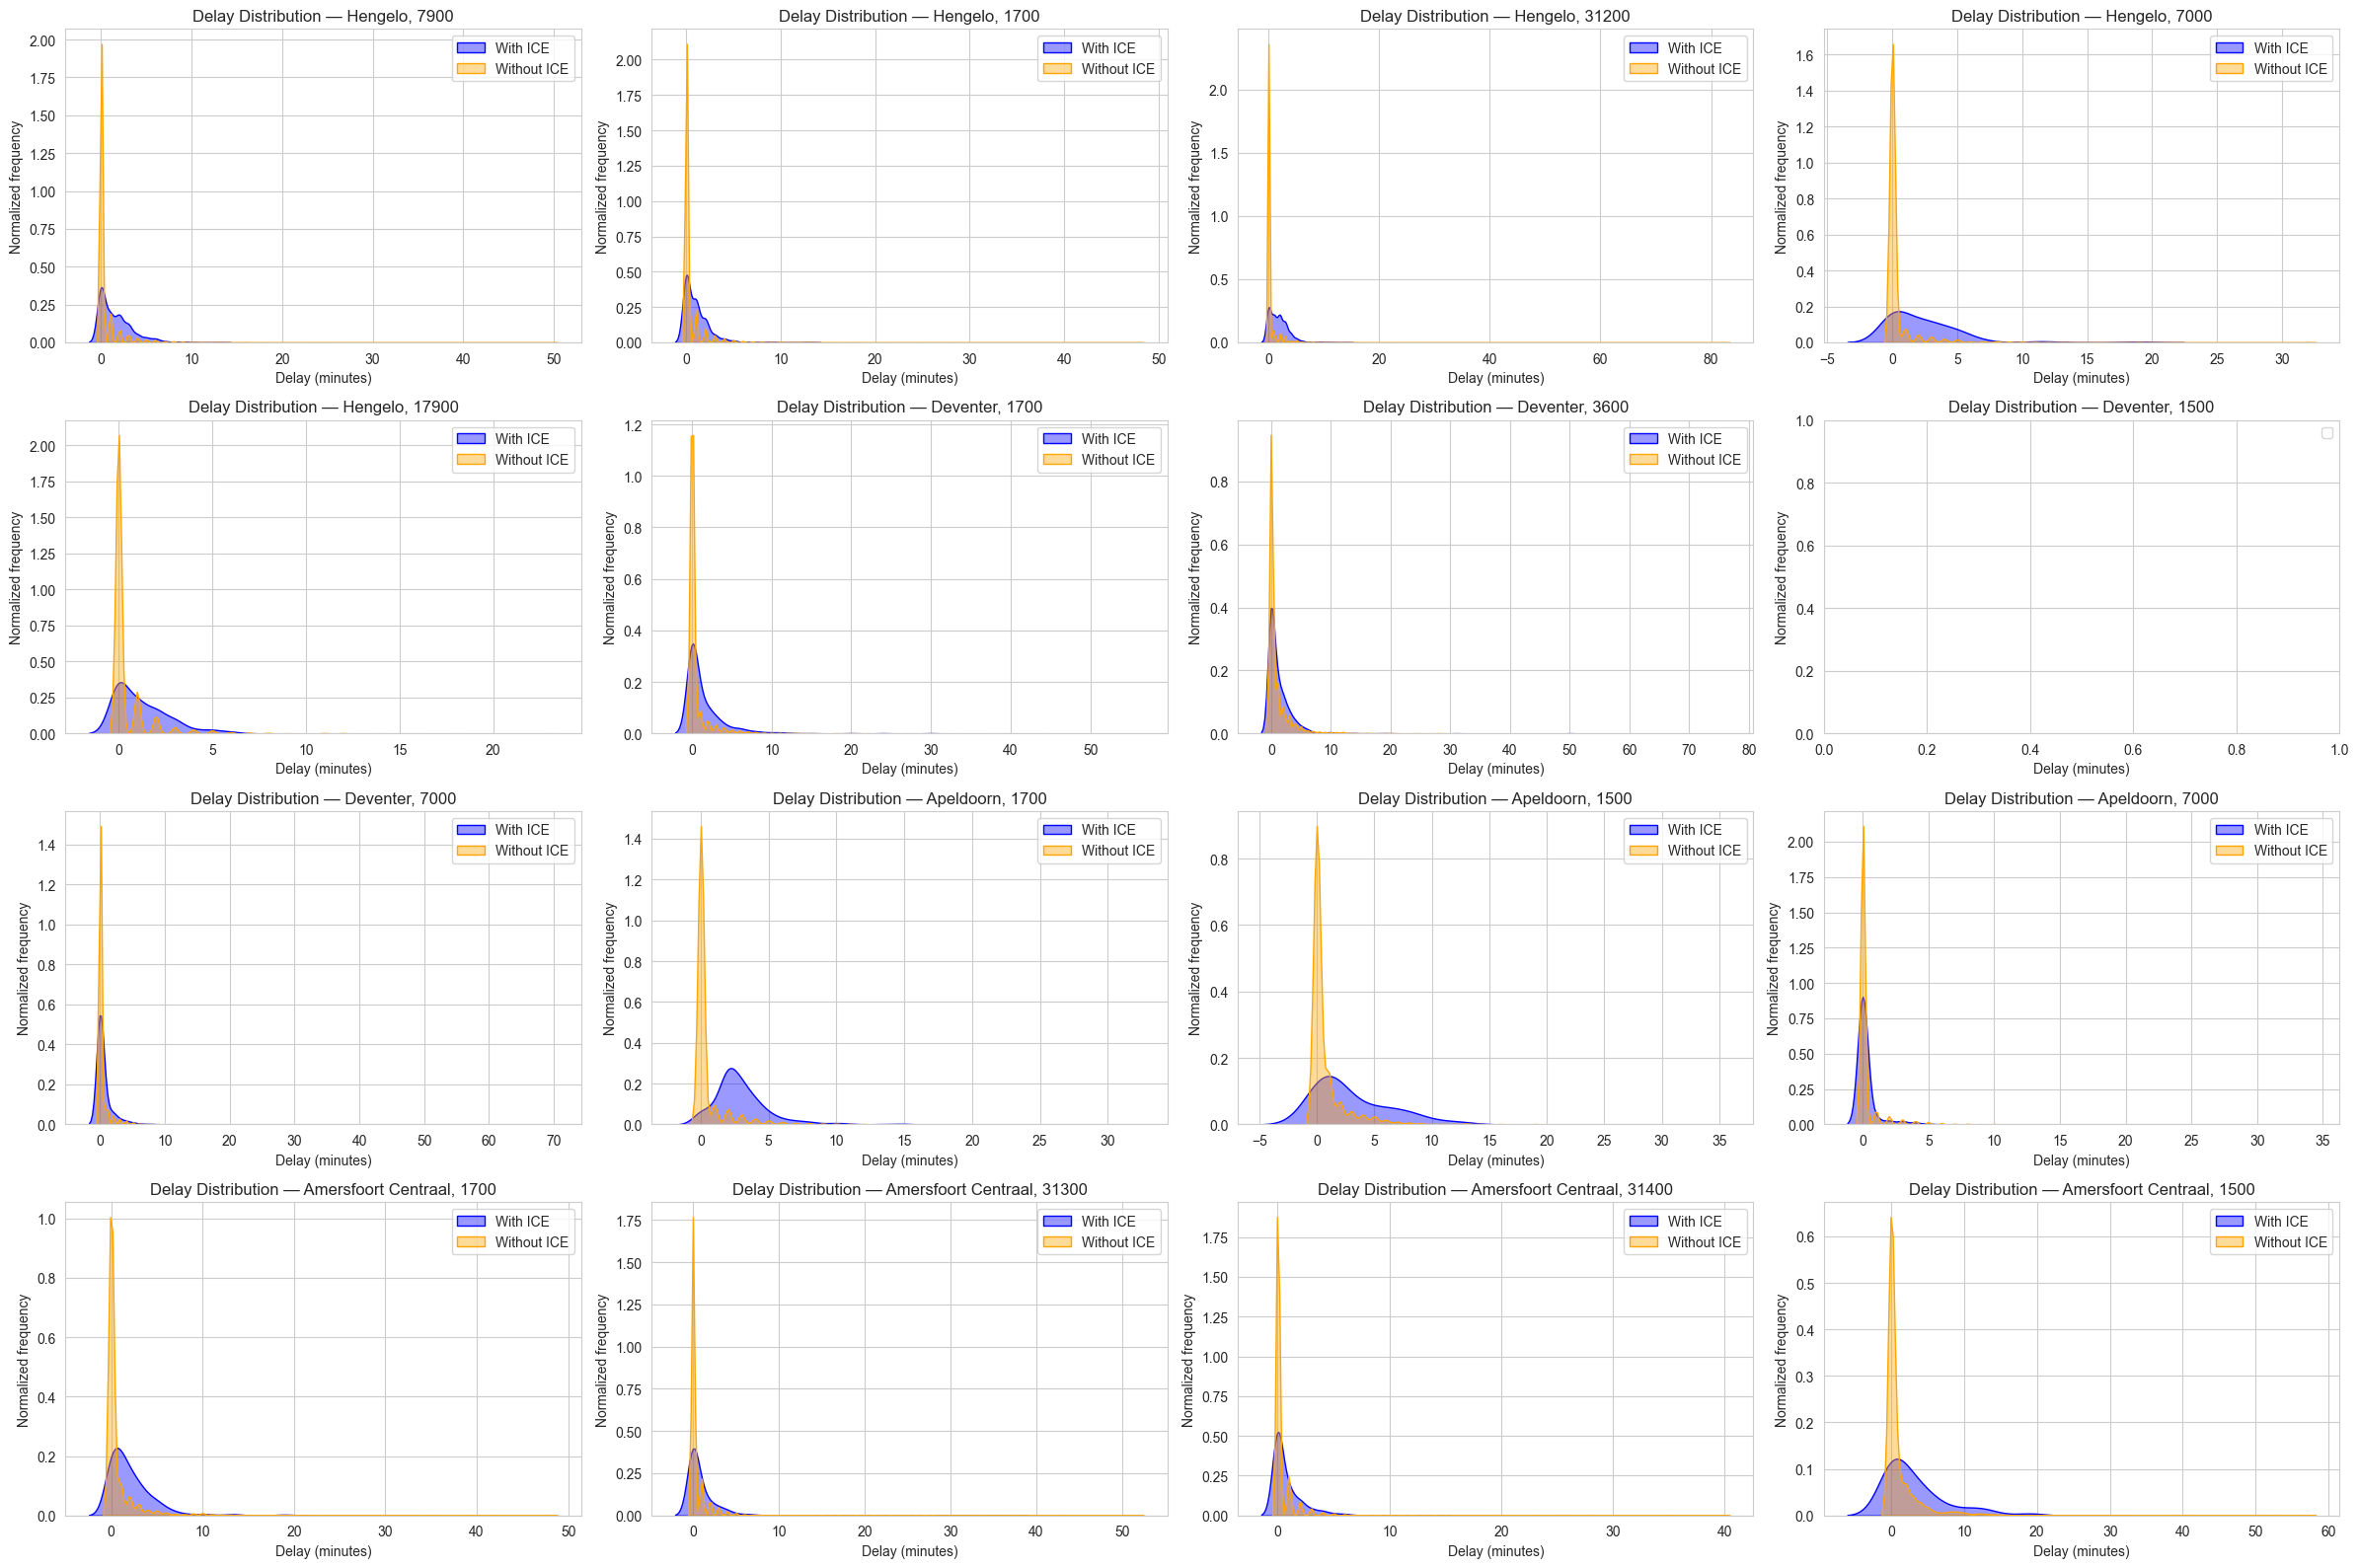

In [ ]:
### VISUALIZATION ###
# ---- Delay distribution ---- #
keys = list(w_ICE.keys())
N = len(keys)

cols = int(np.ceil(np.sqrt(N)))
rows = int(np.ceil(N / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))

if N == 1:
    axes = np.array([axes])
else:
    axes = axes.flatten()

w_ice = 0
wo_ice = 0

for i, key in enumerate(keys):
    ax = axes[i] 
    data1 = np.array(w_ICE[key], dtype=float)
    data2 = np.array(wo_ICE[key], dtype=float)

    data1 = data1[~np.isnan(data1)]
    data2 = data2[~np.isnan(data2)]

    w_ice += len(data1)
    wo_ice += len(data2)

    if len(data1) == 0 and len(data2) == 0:
        ax.set_visible(False) 
        continue

    sns.kdeplot(data1, ax=ax, fill=True, alpha=0.4, label="With ICE", color="blue", common_norm=False)
    sns.kdeplot(data2, ax=ax, fill=True, alpha=0.4, label="Without ICE", color="orange", common_norm=False)

    ax.set_xlabel("Delay (minutes)")
    ax.set_ylabel("Normalized frequency")
    ax.set_title(f"Delay Distribution — {key}")

    ax.legend()
    ax.grid(True)

for i in range(N, rows * cols):
    axes[i].set_visible(False)

fig.tight_layout()

plt.savefig('Secondary_Delay_Distribution.png')
print(w_ice)
print(wo_ice)

In [ ]:
df = pd.read_csv(file_s, sep = ';')


display(all_data_without_ICE)

{'Hengelo':        Service:Date  Service:Train number        Other_Arrival_time  \
 2        2024-01-01                 31278 2024-01-01 19:43:00+00:00   
 3        2024-01-01                  7978 2024-01-01 19:43:00+00:00   
 4        2024-01-01                  1778 2024-01-01 19:53:00+00:00   
 5        2024-01-01                  7980 2024-01-01 20:13:00+00:00   
 6        2024-01-01                 31282 2024-01-01 20:43:00+00:00   
 ...             ...                   ...                       ...   
 467573   2025-10-31                  1732 2025-10-31 08:23:00+00:00   
 467574   2025-10-31                 17934 2025-10-31 08:38:00+00:00   
 467575   2025-10-31                 31234 2025-10-31 08:43:00+00:00   
 467576   2025-10-31                  7934 2025-10-31 08:43:00+00:00   
 467577   2025-10-31                  1734 2025-10-31 08:52:00+00:00   
 
         Other Arrival Delay Hengelo Actual_Other_Arrival_Time  \
 2                               1.0       2024-01-01 19:

In [ ]:
### MEAN PUNCTUALITY DIFFERENCE ###

# ---- with ICE ---- #
table = pd.DataFrame(columns = ['Station', 'Train series', 'Punctuality with ICE interaction'])


delay_def = 3
for i in stations:
    df = station_data_storage[i]
    for j in o_services:
        trainseries = j[:-2]
        filtered_df1 = df[(df['Service:Train number'].astype(str).str[:-2] == trainseries )] 
        if filtered_df1.empty:
            continue
        total_trains = len(filtered_df1)
        trains_delay = (filtered_df1[f'Other Arrival Delay {i}'] > delay_def).sum()
        share = 100-(int(trains_delay)/int(total_trains) * 100)
        dict[f'{j}, {i}'] = round(share, 1)
        data = [i,j, round(share, 1)]
        table.loc[len(table)] = data 
        

# ---- without ICE ---- #
file_s = f'Services/all_interesting_services_complete_day.csv'
df1 = pd.read_csv(file_s, sep = ',')
count = 0

for i in stations:
    for j in o_services:
        trainseries = j[:-2]
        filtered_df1 = df1[(df1['Service:Train number'].astype(str).str[:-2] == trainseries ) & (df1['Stop:Station name'] == i )] 
        if filtered_df1.empty:
            continue
        total_trains = len(filtered_df1)
        trains_delay = (filtered_df1[f'Stop:Arrival delay'] > delay_def).sum()  #A train is delayed is the delay is larger than the definition of a delay
        share = 100-(int(trains_delay)/int(total_trains) * 100)
        table.loc[(table['Station'] == i) & (table['Train series'] == j), 'Punctuality Overall'] = round(share, 1)

table['Punctuality Difference'] = table['Punctuality with ICE interaction'] - table['Punctuality Overall']


for i in stations:
    df = station_data_storage[i] # Data source 1 (station-specific)
    
    for j in o_services:
        trainseries = j[:-2]
        filtereddf1 = df[ (df['Service:Train number'].astype(str).str[:-2] == trainseries ) ]

        filtereddf2 = df1[ (df1['Service:Train number'].astype(str).str[:-2] == trainseries ) & (df1['Stop:Station name'] == i ) ]

        data1 = np.array(filtereddf1[f'Stop:Arrival delay'].tolist())
        data2 = np.array(filtereddf2[f'Stop:Arrival delay'].tolist())
        # --- OPTIMIZATION STEP 2: Check for valid data lengths ---
        if len(data1) < 2 or len(data2) < 2:
            continue 
        print(len(data1))
        print(len(data2))
        # t-test remains correct for comparing two independent, unequally-sized samples
        t_statistic, p_value = stats.ttest_ind(
            data1,
            data2,
            equal_var=False) # Correctly using Welch's t-test
            
        print(f"Results: {i}, {j}")
        print(f"T-statistic: {t_statistic:.4f}")
        print(f"P-value: {p_value:.4f}")


table.to_excel(f'Impact of ICE Interaction on Mean Punctuality (Arrival) per Train Series.xlsx', index=False)
print(table)


1165
24460
Results: Hengelo, 7900
T-statistic: nan
P-value: nan
569
16771
Results: Hengelo, 1700
T-statistic: nan
P-value: nan
1082
23917
Results: Hengelo, 31200
T-statistic: nan
P-value: nan
102
4000
Results: Hengelo, 7000
T-statistic: 28.4248
P-value: 0.0000
145
6171
Results: Hengelo, 17900
T-statistic: nan
P-value: nan
772
17426
Results: Deventer, 1700
T-statistic: nan
P-value: nan
1683
23587
Results: Deventer, 3600
T-statistic: nan
P-value: nan
2
5536
Results: Deventer, 1500
T-statistic: nan
P-value: nan
983
21399
Results: Deventer, 7000
T-statistic: nan
P-value: nan
463
17470
Results: Apeldoorn, 1700
T-statistic: nan
P-value: nan
31
5553
Results: Apeldoorn, 1500
T-statistic: nan
P-value: nan
677
20060
Results: Apeldoorn, 7000
T-statistic: 42.3027
P-value: 0.0000
495
17265
Results: Amersfoort Centraal, 1700
T-statistic: nan
P-value: nan
583
23874
Results: Amersfoort Centraal, 31300
T-statistic: 22.3435
P-value: 0.0000
359
13434
Results: Amersfoort Centraal, 31400
T-statistic: 41.33

**Treinseries:**<br>
         1700: Enschede - Den Haag Centraal<br>
         7000: Almelo - Apeldoorn<br>
         7900: Enschede - Zwolle<br>
         3600: Zwolle - Roosendaal<br>
         31300: Amersfoort - Ede-Wageningen<br>
         31400: Amersfoort - Barneveld-Zuid<br>
         17900: Enschede - Zwolle IC<br>
         31200: Zutphen - Oldenzaal<br>
         1500: Deventer - Amsterdam"

